## A1: Data Curation

The purpose of this notebook is to showcase a dataset, whilst adhering to principles of reproducible research. The reference articles used for this purpose are:
1. [Assessing Reproducibility](http://www.practicereproducibleresearch.org/core-chapters/2-assessment.html)
2. [The Basic Reproducible Workflow Template](http://www.practicereproducibleresearch.org/core-chapters/3-basic.html)

## Table of Contents
1. Step 1 : Data Acquisition  - collecting counts of pageviews using a specified subset of Wikipedia article pages. 
2. Step 2 : Data Processing
3. Step 3 : Analysis


In [1]:
#importing the python modules 
import json, time, urllib.parse
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import math
import numpy as np
from datetime import datetime
import os
import shutil
%matplotlib inline
pd.plotting.register_matplotlib_converters()
warnings.filterwarnings("ignore")

## Step 1 - Data Acquisition

We use PageView Wikimedia API to collect the data. The Pageviews API (documentation, endpoint) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through the previous complete month.
1. [documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews)
2. [endpoint](https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)


In [2]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests

API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

In [3]:
# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request

API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

REQUEST_HEADERS = {
    'User-Agent': '<sdawark@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

In [4]:
#This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. 
#The dictionary has a field/key for each of the required parameters.

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      
    "agent":       "user",
    "article":     "",             
    "granularity": "monthly",
    "start":       "2015070100",  #start-date
    "end":         "2022100100"   #end-date
}

In [5]:
# Reading the excel file containing urls for each page

data_file = pd.read_excel('/Users/qwert/Documents/UW_Data_Science/Human_Centered_Data_Science/Homeworks/data-512-homework_1/csv/dinosaur_genera.cleaned.SEPT.2022.xlsx')
data_file_url = data_file['name']

In [6]:
ARTICLE_TITLES = list(data_file_url)

In [7]:
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    
    """
    This function helps us to get pageview data for each ARTICLE_TITLES
    """

    if not article_title: return None
    
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    try:
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [8]:
def Output_Json(file_name,access_type, start_date, end_date, data):
    """
    This function dumps the list of dictionaries in JSON format
    """
    file_path = file_name + '_' + access_type + '_' + start_date + '-' + end_date + '.json'
    with open(file_path, "w") as outfile:
        json.dump(data, outfile)

In [9]:
#Looping through all the access types and get the page views

ACCESS_TYPES = ['desktop','mobile-web','mobile-app']

start_date = 'start{}'.format(201501)
end_date = 'end{}'.format(202210)

for access in ACCESS_TYPES:
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = access

    data = []
    for i in range(0, len(ARTICLE_TITLES)):
        views = request_pageviews_per_article(ARTICLE_TITLES[i])
        if 'items' in views and len(views['items']) !=0:
            item_list = views['items']
            data += item_list
    Output_Json('dino_monthly',access,start_date,end_date, data)
    print(access, 'success')

desktop success
mobile-web success
mobile-app success


## Step 2 - Data Processing

Reading the JSON file for the mobile -app

In [10]:
df_mobile_app = pd.read_json("json/dino_monthly_mobile-app_start201501-end202210.json")

print("The numner of rows for mobile app : {}".format(len(df_mobile_app)))



The numner of rows for mobile app : 112610


Reading the JSON file for the mobile -app

In [11]:
df_mobile_web = pd.read_json("json/dino_monthly_mobile-web_start201501-end202210.json")

print("The numner of rows for web app : {}".format(len(df_mobile_web)))

The numner of rows for web app : 112610


In [12]:
def read_json(filename):
    """
    The function reads the JSON file
    """
    data = {}
    with open(filename, 'r') as f:
        data = json.loads(f.read())
        
    return data

Reading the 3 JSON files - desktop, mobile-app, movile-web

In [13]:
VIEWS_DESKTOP = read_json('json/dino_monthly_desktop_start201501-end202210.json')
VIEWS_MOBILE_APP = read_json('json/dino_monthly_mobile-app_start201501-end202210.json')
VIEWS_MOBILE_WEB = read_json('json/dino_monthly_mobile-web_start201501-end202210.json')

Converting the JSON files to pandas DataFrame

In [14]:
df_desktop = pd.DataFrame(VIEWS_DESKTOP)
df_mobile_app = pd.DataFrame(VIEWS_MOBILE_APP)
df_mobile_web = pd.DataFrame(VIEWS_MOBILE_WEB)

In [15]:
def split_date_month(df, col_name):
    "The function splits the yyyymmdd format to yyyymm format applied to dataframe column"
    df['year'] = df[col_name].str[0:4]
    df['month'] = df[col_name].str[4:6]
    df['date'] = df['year'].astype(str) + '-'+ df['month'].astype(str)
    df.index = pd.to_datetime(df['date'])
    df['log_views'] = np.log2(df['views'])  
    return df.head(5)

Path where csv files will be stored

In [16]:
csv_path = '/Users/qwert/Documents/UW_Data_Science/Human_Centered_Data_Science/Homeworks/data-512-homework_1/csv/'

Applying the split date month function on df_desktop column timestamp

In [17]:
# Applying the split date month function on df_desktop column timestamp
split_date_month(df_desktop, 'timestamp')
df_desktop.to_csv(csv_path + 'df_desktop.csv')
df_desktop.head(5)

,project,article,granularity,timestamp,access,agent,views,year,month,date,log_views
date,,,,,,,,,,,
2015-07-01,en.wikipedia,Aachenosaurus,monthly,2015070100,desktop,user,2671,2015,07,2015-07,11.383164
2015-08-01,en.wikipedia,Aachenosaurus,monthly,2015080100,desktop,user,13113,2015,08,2015-08,13.678710
2015-09-01,en.wikipedia,Aachenosaurus,monthly,2015090100,desktop,user,34235,2015,09,2015-09,15.063184
2015-10-01,en.wikipedia,Aachenosaurus,monthly,2015100100,desktop,user,5361,2015,10,2015-10,12.388286
2015-11-01,en.wikipedia,Aachenosaurus,monthly,2015110100,desktop,user,13502,2015,11,2015-11,13.720886


In [18]:
# Applying the split date month function on df_mobile_app column timestamp

split_date_month(df_mobile_app, 'timestamp')
df_mobile_app.to_csv(csv_path + 'df_mobile_app.csv')
df_mobile_app.head(5)

,project,article,granularity,timestamp,access,agent,views,year,month,date,log_views
date,,,,,,,,,,,
2015-07-01,en.wikipedia,Aachenosaurus,monthly,2015070100,mobile-app,user,14,2015,07,2015-07,3.807355
2015-08-01,en.wikipedia,Aachenosaurus,monthly,2015080100,mobile-app,user,15,2015,08,2015-08,3.906891
2015-09-01,en.wikipedia,Aachenosaurus,monthly,2015090100,mobile-app,user,8,2015,09,2015-09,3.000000
2015-10-01,en.wikipedia,Aachenosaurus,monthly,2015100100,mobile-app,user,5,2015,10,2015-10,2.321928
2015-11-01,en.wikipedia,Aachenosaurus,monthly,2015110100,mobile-app,user,9,2015,11,2015-11,3.169925


In [19]:
# Applying the split date month function on df_mobile_web column timestamp

split_date_month(df_mobile_web, 'timestamp')
df_mobile_app.to_csv(csv_path + 'df_mobile_web.csv')
df_mobile_web.head(5)

,project,article,granularity,timestamp,access,agent,views,year,month,date,log_views
date,,,,,,,,,,,
2015-07-01,en.wikipedia,Aachenosaurus,monthly,2015070100,mobile-web,user,429,2015,07,2015-07,8.744834
2015-08-01,en.wikipedia,Aachenosaurus,monthly,2015080100,mobile-web,user,397,2015,08,2015-08,8.632995
2015-09-01,en.wikipedia,Aachenosaurus,monthly,2015090100,mobile-web,user,275,2015,09,2015-09,8.103288
2015-10-01,en.wikipedia,Aachenosaurus,monthly,2015100100,mobile-web,user,789,2015,10,2015-10,9.623881
2015-11-01,en.wikipedia,Aachenosaurus,monthly,2015110100,mobile-web,user,302,2015,11,2015-11,8.238405


Combining the counts for the mobile (web and app) in 1 single JSON file

In [20]:
df_mobile = df_mobile_web
df_mobile['views'] = df_mobile_app['views'] + df_mobile_web['views'] 
df_mobile['access'] = 'mobile'
df_mobile.to_json('json/dino_monthly_mobile_start201501-end202209.json',orient='records')

Combining the mobile and desktop views in 1 single dataframe

In [21]:
df_cummulative = df_mobile
df_cummulative['views'] = df_mobile['views'] + df_desktop['views']
df_cummulative.to_csv(csv_path + 'df_cummulative_mobile.csv')
df_cummulative.head(3)

,project,article,granularity,timestamp,access,agent,views,year,month,date,log_views
date,,,,,,,,,,,
2015-07-01,en.wikipedia,Aachenosaurus,monthly,2015070100,mobile,user,3114,2015,07,2015-07,8.744834
2015-08-01,en.wikipedia,Aachenosaurus,monthly,2015080100,mobile,user,13525,2015,08,2015-08,8.632995
2015-09-01,en.wikipedia,Aachenosaurus,monthly,2015090100,mobile,user,34518,2015,09,2015-09,8.103288


In [22]:
#Saving the file in JSON format

df_cummulative.to_json('json/dino_monthly_cumulative_start201501-end202209.json',orient='records')

## Step 3 - Analysis 


### Maximum Average and Minimum Average 

In [23]:
df_desktop_access = df_desktop
df_mobile_access = df_cummulative

Grouping the articles and doing aggregation on views

In [24]:
result_mobile = df_mobile.groupby('article').agg({'views': ['mean']})


Filtering the article with max average views for mobile access

In [25]:
result_mobile['views','mean'].idxmax()

'Tyrannosaurus'

Filtering the article with min average views for mobile access

In [26]:
result_mobile['views','mean'].idxmin()

'Honghesaurus'

Filtering the article with max average views for desktop access

In [27]:
result_mobile.loc[result_mobile['views'].idxmax()]

,views
,mean
article,
Tyrannosaurus,105943.701149


Filtering the article with min average views for desktop access

In [28]:
result_mobile.loc[result_mobile['views'].idxmin()]

,views
,mean
article,
Honghesaurus,22.850575


Subsetting the data for max and min articles for mobile access

In [29]:
df_mobile_max = df_mobile.loc[df_mobile['article'] == 'Tyrannosaurus']
df_mobile_max['type'] = 'max mobile'
df_mobile_min = df_mobile.loc[df_mobile['article'] == 'Honghesaurus']
df_mobile_min['type'] = 'min mobile'


Grouping by article and then aggregating based on views for desktop access

In [30]:
result_desktop = df_desktop.groupby('article').agg({'views': ['mean']})
result_desktop.head(2)

,views
,mean
article,
Aachenosaurus,1606.356322
Aardonyx,638.954023


Filtering the article with max average views for desktop access

In [31]:
result_desktop['views','mean'].idxmax()

'Tyrannosaurus'

Filtering the article with min average views for desktop access

In [32]:
result_desktop['views','mean'].idxmin()

'Honghesaurus'

In [33]:
result_desktop.loc[result_desktop['views'].idxmax()]

,views
,mean
article,
Tyrannosaurus,46406.0


In [34]:
result_desktop.loc[result_desktop['views'].idxmin()]

,views
,mean
article,
Honghesaurus,16.965517


Subsetting the data for max and min articles for desktop access

In [35]:
df_desktop_max = df_desktop.loc[df_desktop['article'] == 'Tyrannosaurus']
df_desktop_max['type'] = 'max desktop'

df_desktop_min = df_desktop.loc[df_desktop['article'] == 'Honghesaurus']
df_desktop_min['type'] = 'min desktop'

In [36]:
final_df = pd.concat([df_desktop_min, df_desktop_max,df_mobile_min, df_mobile_max], axis=0)
final_df['log_views'] = np.log2(final_df['views'])

Plotting Maximum Average and Minimum Average for desktop and mobile access for page requests

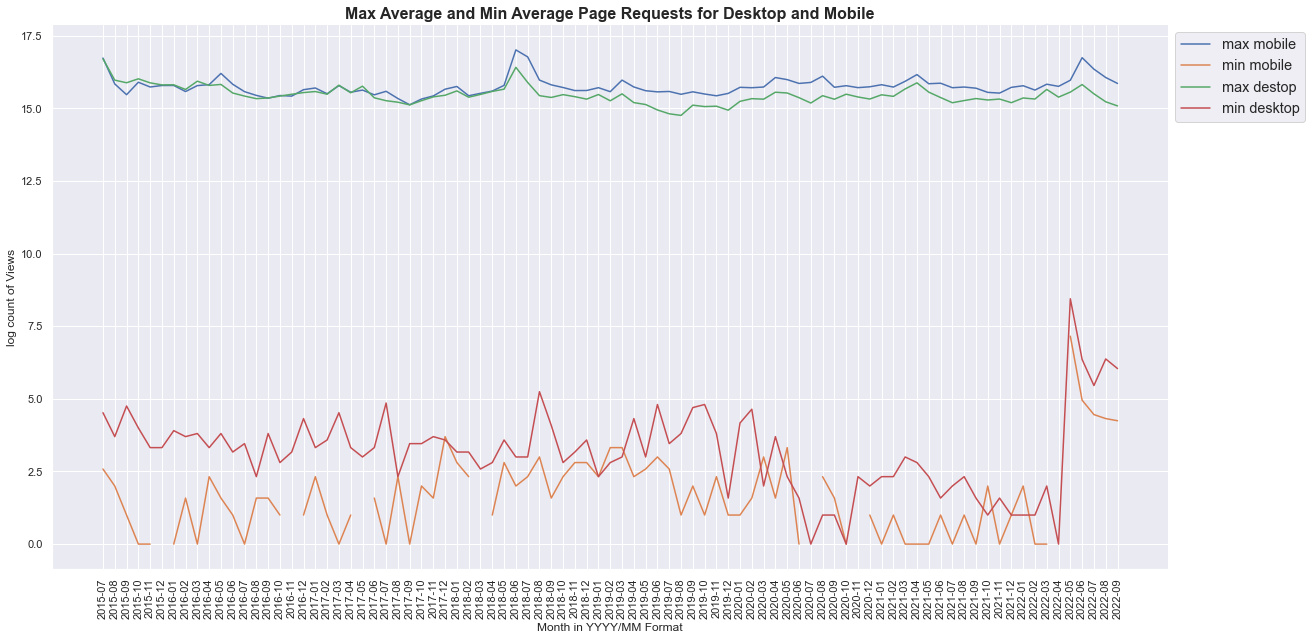

In [67]:
labels = ["max mobile","min mobile", "max destop", "min desktop"]
plt.figure(figsize = (20,10))
plt.plot(df_mobile_max["date"],df_mobile_max["log_views"])
plt.plot(df_mobile_min["date"],df_mobile_min["log_views"])
plt.plot(df_desktop_max["date"],df_desktop_max["log_views"])
plt.plot(df_desktop_min["date"],df_desktop_min["log_views"])
plt.title("Max Average and Min Average Page Requests for Desktop and Mobile",fontsize = 16, fontweight='bold')
plt.xlabel("Month in YYYY/MM Format")
plt.ylabel("log count of Views")
plt.legend(labels = labels, fontsize = "large", bbox_to_anchor=(1,1))
plt.xticks(rotation=90)
sns.despine()
plt.show()

In [39]:
plot_path = '/Users/qwert/Documents/UW_Data_Science/Human_Centered_Data_Science/Homeworks/data-512-homework_1/plots/'

In [40]:
plt.savefig(plot_path + 'Max_Average_and_Min_Average_Page_Requests_for_Desktop_and_Mobile.png');

<Figure size 432x288 with 0 Axes>

### Top 10 Peak Page Views

Filtering top 10 articles for desktop and mobile access

In [41]:
# Get max views for each article
df_top_10_mobile = df_mobile.groupby(['article'], as_index=False)['views'].max().nlargest(10, 'views').set_index('article')
df_top_10_desktop = df_desktop.groupby(['article'], as_index=False)['views'].max().nlargest(10, 'views').set_index('article')


mobile_subset =  df_mobile[df_mobile['article'].isin(df_top_10_mobile.index)]
desktop_subset =  df_desktop[df_mobile['article'].isin(df_top_10_desktop.index)]


desktop_subset['access'] = '(desktop)'
desktop_subset['dino_access'] = desktop_subset['access']+ '' +desktop_subset['article']



mobile_subset['access'] = '(mobile)'
mobile_subset['dino_access'] = mobile_subset['access']+ '' +mobile_subset['article']

Concatenating top 10 for desktop abd mobile access

In [42]:
final_top_10 = pd.concat([desktop_subset, mobile_subset], axis =0)

Plotting the graph for the Top 10 Articles by Peak Page Views and Access Type

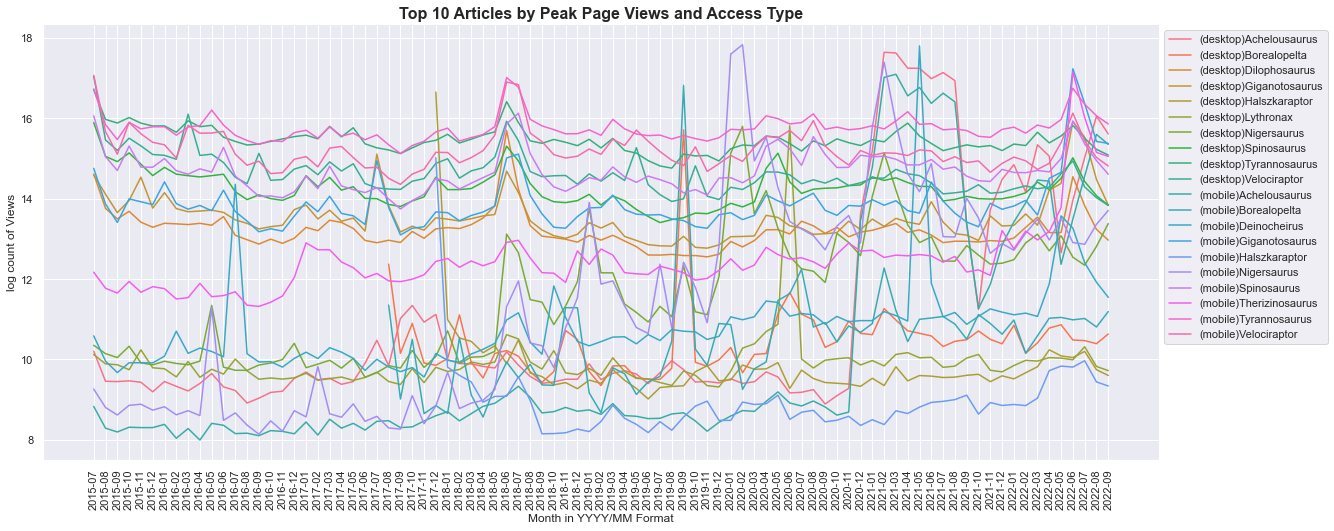

In [43]:
sns.set(rc={"figure.figsize":(20, 8)}) #width=20, height=8
ax = sns.lineplot(x='date', y='log_views', hue='dino_access', data=final_top_10,ci=None)
plt.title("Top 10 Articles by Peak Page Views and Access Type",fontsize = 16, fontweight='bold')
plt.xlabel("Month in YYYY/MM Format")
plt.ylabel("log count of Views")
plt.legend(bbox_to_anchor=(1,1));
plt.xticks(rotation=90)
sns.despine()
plt.show()

Saving the plot in the folder

In [44]:
plt.savefig(plot_path + 'Top_10_Articles_by_Peak_Page_Views_and_Access_Type.png');

<Figure size 1440x576 with 0 Axes>

### Fewest Months of Data 

Sorting the bottom views for desktop access

In [45]:
dino_desktop_btm = df_desktop.groupby(['article'])['views'].count().sort_values()[:10]

dino_desktop_btm = list(dino_desktop_btm.index)

Sorting the bottom views for mobile access

In [46]:
dino_mobile_btm = df_mobile.groupby(['article'])['views'].count().sort_values()[:10]
dino_mobile_btm = list(dino_mobile_btm.index)

Filtering the data based on bottom 10 for desktop access

In [47]:
desk_subset_btm =  df_desktop[df_desktop['article'].isin(dino_desktop_btm)]
desk_subset_btm['Date'] = pd.to_datetime(desk_subset_btm.assign(Day=1).loc[:, ['year','month','Day']])
desk_subset_btm['access'] = '(desktop)'
desk_subset_btm['dino_access'] = desk_subset_btm['access']+ '' +desk_subset_btm['article']
desk_subset_btm['views'] = np.log2(desk_subset_btm['views'])
desk_subset_btm.head(2)

,project,article,granularity,timestamp,access,agent,views,year,month,date,log_views,Date,dino_access
date,,,,,,,,,,,,,
2022-03-01,en.wikipedia,Bashanosaurus,monthly,2022030100,(desktop),user,11.199059,2022,03,2022-03,11.199059,2022-03-01,(desktop)Bashanosaurus
2022-04-01,en.wikipedia,Bashanosaurus,monthly,2022040100,(desktop),user,8.774787,2022,04,2022-04,8.774787,2022-04-01,(desktop)Bashanosaurus


Filtering the data based on bottom 10 for mobile access

In [48]:
mobile_subset_btm =  df_mobile[df_mobile['article'].isin(dino_mobile_btm)]
mobile_subset_btm['Date'] = pd.to_datetime(mobile_subset_btm.assign(Day=1).loc[:, ['year','month','Day']])
mobile_subset_btm['access'] = '(mobile)'
mobile_subset_btm['dino_access'] = mobile_subset_btm['access']+ '' +mobile_subset_btm['article']
mobile_subset_btm['views'] = np.log2(mobile_subset_btm['views'])
mobile_subset_btm.head(2)

,project,article,granularity,timestamp,access,agent,views,year,month,date,log_views,Date,dino_access
date,,,,,,,,,,,,,
2022-03-01,en.wikipedia,Bashanosaurus,monthly,2022030100,(mobile),user,11.883789,2022,03,2022-03,10.428360,2022-03-01,(mobile)Bashanosaurus
2022-04-01,en.wikipedia,Bashanosaurus,monthly,2022040100,(mobile),user,9.577429,2022,04,2022-04,8.303781,2022-04-01,(mobile)Bashanosaurus


Concatenating the bottom 10 results for desktop and mobile access

In [49]:
final = pd.concat([desk_subset_btm,mobile_subset_btm ], axis =0)

Plotting the graph for the fewest month of data 

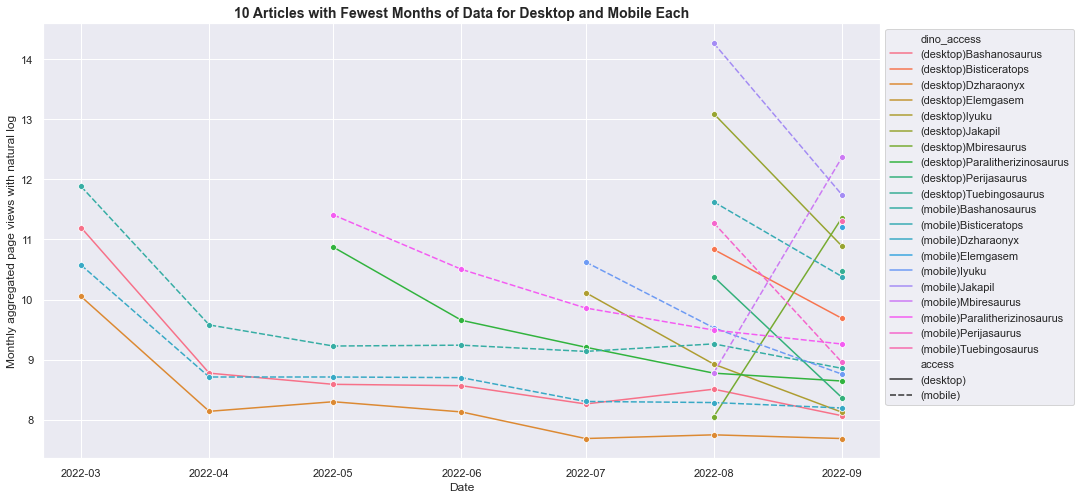

In [50]:
sns.set(rc={"figure.figsize":(15, 8)}) #width=20, height=8
ax = sns.lineplot(x='Date', y='views', hue='dino_access', data=final,ci=None,marker = 'o',style="access")
plt.xlabel("Date", size=12)
plt.ylabel("Monthly aggregated page views with natural log", size=12)
plt.title('10 Articles with Fewest Months of Data for Desktop and Mobile Each', size=14,weight='bold');
plt.legend(bbox_to_anchor=(1,1));

Saving the plot in the folder

In [ ]:
plt.savefig(plot_path + 'Bottom_10_Articles_with_Fewest_Months_of_Data_for_Desktop_and_Mobile_Each.png');